In [ ]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import modules.extended_model as em
import modules.aguilera_model as am
import importlib

In [31]:
importlib.reload(em)

<module 'extended_model' from 'c:\\Users\\marka\\OneDrive\\Documents\\Uni\\Edinburgh Uni\\S1\\Industrial Maths\\Housing_Multiple_IM\\extended_model.py'>

In [2]:
london = np.loadtxt("london_map_array.txt")
london = np.where(london == 0,-1,london)

In [3]:
def plot_grid(house_grid, step):
    """
    Plot the current state of the grid.
    """
    plt.imshow(house_grid, cmap='plasma', origin='upper')
    plt.title(f'Step {step}')
    plt.colorbar(label='House Value')
    plt.show()
    plt.pause(0.5)
    clear_output(wait=True)
    display(plt.gcf())

In [5]:
n = 100
lambda_ = 0.65
r = 2
p_affluence = [0.16, 0.6, 0.24]
p_ethnicities = [0.207,0.135,0.057,0.368,0.170,0.063]
w_ethnicity = 1/2
affluence_levels = {
    "rich": 1,
    "middle": 0.5,
    "poor": 0.1
}

In [ ]:
# Simulation parameters
n_steps = 4000
n_swaps_per_step = 30
affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid = em.initialise_house_and_demog_grids(london, affluence_levels, p_affluence, p_ethnicities)

# fig, ax = plt.subplots()
# fig.suptitle('Step 0')
# img = plt.imshow(house_grid, cmap='viridis',vmin=0, vmax=3.5)

# cbar = fig.colorbar(img, ax=ax)
# cbar.set_label('House Price')

# Simulation loop
for step in range(n_steps):
    print(f"{step=}")
    # Update house values
    house_grid = am.calculate_new_house_values_conv(house_grid, affluence_grid, r, lambda_, calc_num_neighbours = True)
    
    # Propose random move - several in each step
    for i in range(n_swaps_per_step):
        em.make_swap(affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid, 0, 0, w_ethnicity, r)

    # img.set_array(house_grid)
    # img.set_clim(vmax = np.max(house_grid))
    # fig.suptitle(f"Step {step}")
    # plt.pause(0.001)
    # clear_output(wait=True)
    # display(fig)
    

step=0
step=1
step=2
step=3
step=4
step=5
step=6
step=7
step=8
step=9
step=10
step=11
step=12
step=13
step=14
step=15
step=16
step=17
step=18
step=19
step=20
step=21
step=22
step=23
step=24
step=25
step=26
step=27
step=28
step=29
step=30
step=31
step=32
step=33
step=34
step=35
step=36
step=37
step=38
step=39
step=40
step=41
step=42
step=43
step=44
step=45
step=46
step=47
step=48
step=49
step=50
step=51
step=52
step=53
step=54
step=55
step=56
step=57
step=58
step=59
step=60
step=61
step=62
step=63
step=64
step=65
step=66
step=67
step=68
step=69
step=70
step=71
step=72
step=73
step=74
step=75
step=76
step=77
step=78
step=79
step=80
step=81
step=82
step=83
step=84
step=85
step=86
step=87
step=88
step=89
step=90
step=91
step=92
step=93
step=94
step=95
step=96
step=97
step=98
step=99
step=100
step=101
step=102
step=103
step=104
step=105
step=106
step=107
step=108
step=109
step=110
step=111
step=112
step=113
step=114
step=115
step=116
step=117
step=118
step=119
step=120
step=121
step=122
ste

KeyboardInterrupt: 

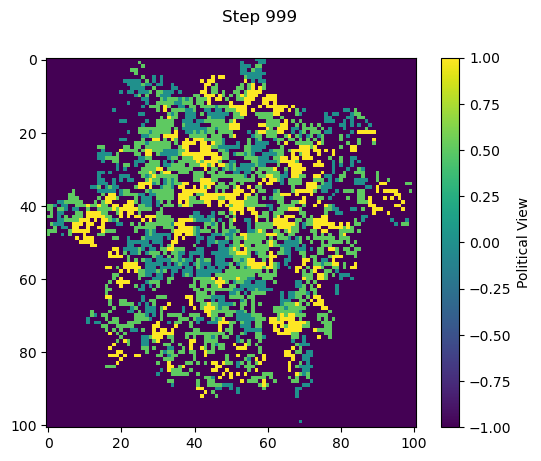

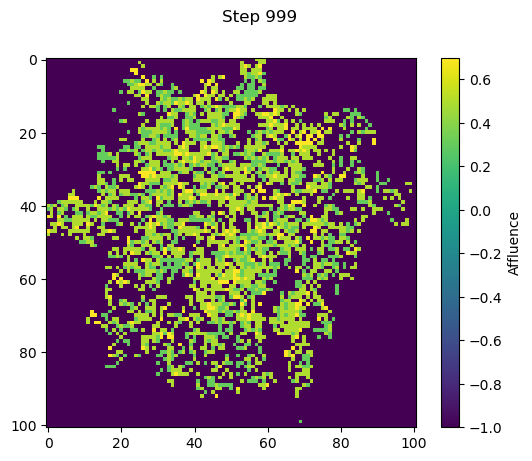

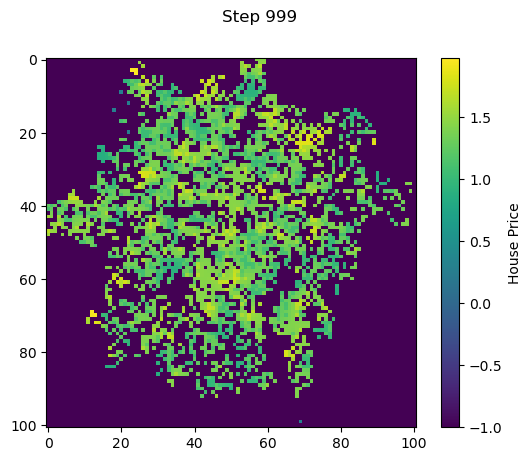

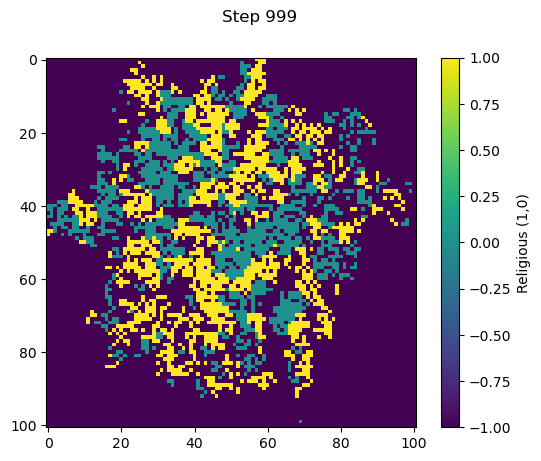

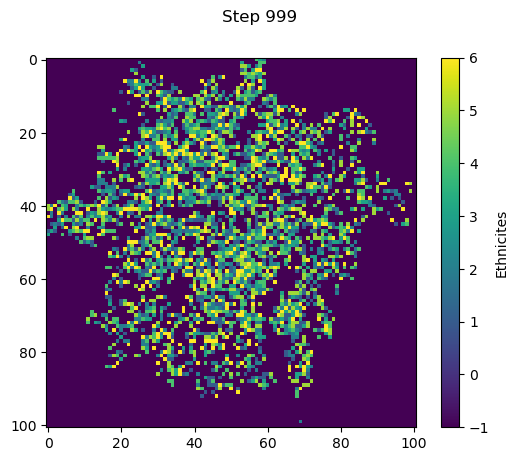

In [53]:
img.set_array(politics_grid)
img.set_clim(vmin = -1, vmax = np.max(politics_grid))
cbar.set_label('Political View')
display(fig)
img.set_array(affluence_grid)
img.set_clim(vmin = np.min(affluence_grid), vmax = np.max(affluence_grid))
cbar.set_label('Affluence')
display(fig)
img.set_array(house_grid)
img.set_clim(vmax = np.max(house_grid))
cbar.set_label('House Price')
display(fig)
img.set_array(religion_grid)
img.set_clim(vmin = -1, vmax = np.max(religion_grid))
cbar.set_label('Religious (1,0)')
display(fig)
img.set_array(ethnicity_grid)
img.set_clim(vmin =-1, vmax = np.max(ethnicity_grid))
cbar.set_label('Ethnicites')
display(fig)

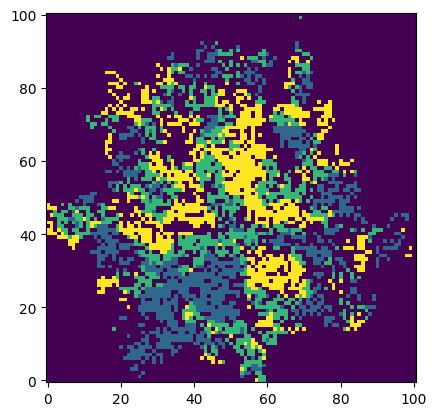

In [7]:
hp_array = house_grid[house_grid > -1]
percentile_33 = np.percentile(hp_array, 33.3)
percentile_67 = np.percentile(hp_array, 66.7)

hp_matrix_binned = np.ones_like(house_grid)
m,n = hp_matrix_binned.shape
for i in range(m):
    for j in range(n):
        price = house_grid[i,j]
        if price != -1:
            if price <= percentile_33:
                hp_matrix_binned[i,j] = 2
            elif price <= percentile_67:
                hp_matrix_binned[i,j] = 3
            else:
                hp_matrix_binned[i,j] = 4


plt.imshow(hp_matrix_binned, origin = 'lower')
plt.show()

In [ ]:
import modules.spatial_seg as spseg

In [9]:
with open("london_exp_entropy.txt") as f:
    expected_entropy = float(f.read())

# Calc London segregation index
london_sp_seg = spseg.spatial_segregation(hp_matrix_binned, expected_entropy)
london_sp_seg

np.float64(0.11614086903566312)